## doubling size of solar in attempt to store

Ramp rates (MW/hour): {3: array([14.99991163]), 4: array([9.99938364]), 5: array([50.00747873])}
                                     CVXPY                                     
                                     v1.6.0                                    
(CVXPY) Jan 27 03:07:50 PM: Your problem has 1176 variables, 101799 constraints, and 0 parameters.
(CVXPY) Jan 27 03:07:50 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 27 03:07:50 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jan 27 03:07:50 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jan 27 03:07:50 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
------------------------------------------------

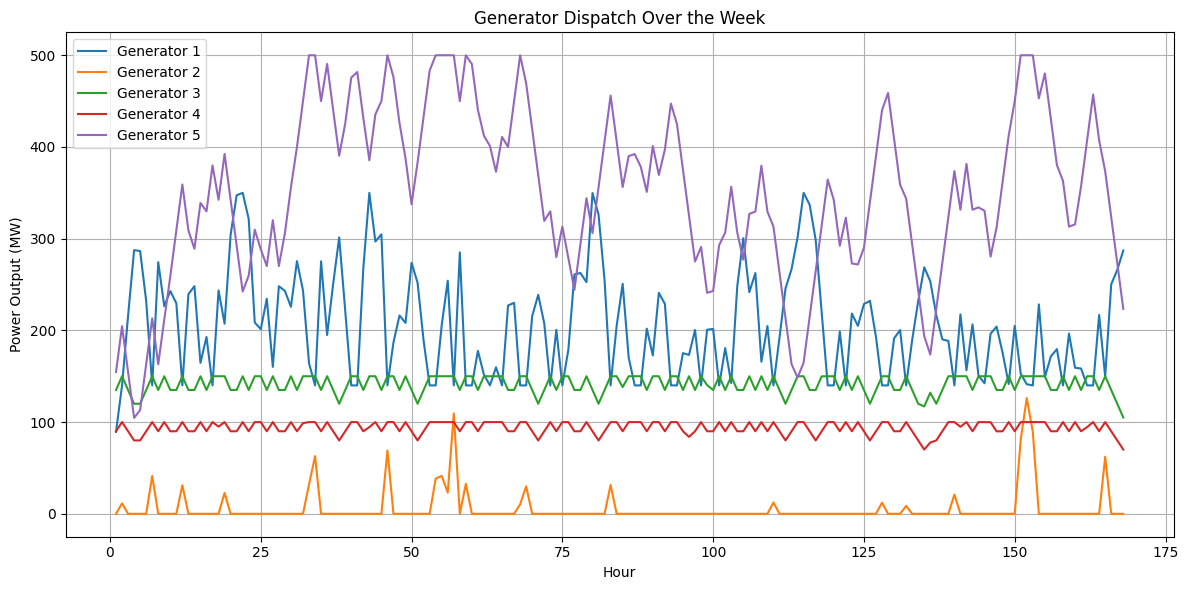

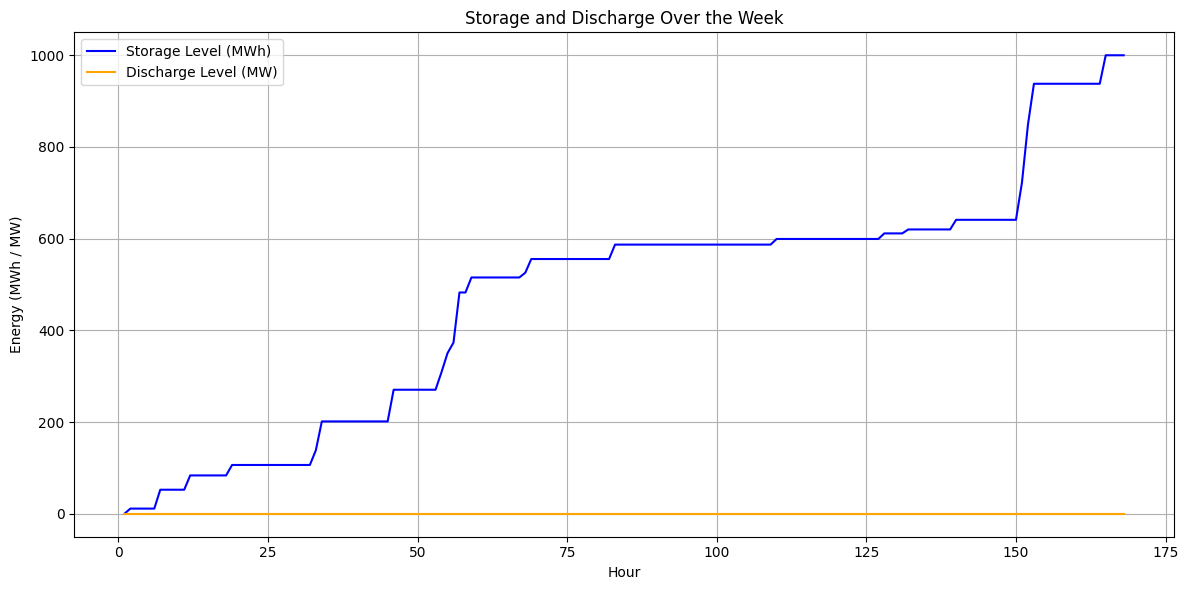

In [18]:
# GEN 1: WIND
# GEN 2: SOLAR
# GEN 3, 4, 5: COAL N GAS

# IMPORT LIBRARIES
import pandas as pd
import numpy as np
import cvxpy as cp
from ddeint import ddeint
import matplotlib.pyplot as plt

# -------------------------------------------------------------------------------------------------------
# INPUT DATA
generator_data = pd.read_csv("provided_material/generators.csv", index_col=0)
node_demands = pd.read_csv("provided_material/hourlydemandbynode.csv", index_col=0)
shift_factor_matrix = pd.read_csv("provided_material/shiftfactormatrix.csv", index_col=0)
line_ratings = pd.read_csv("provided_material/lineratings.csv", index_col=0)

# -------------------------------------------------------------------------------------------------------
# EXTRACT REQUIRED INFO FROM INPUT DATA
gen_IDs = np.array(generator_data.loc[:, "NODE"].astype(int))
gen_marginal_costs = np.array(generator_data.loc[:, "MC"])  # (£/MWh)
gen_capacities = np.array(generator_data.loc[:, "CAP"])  # (MW)

demand_IDs = np.array(node_demands.columns.astype(int))
node_IDs = np.array(shift_factor_matrix.columns.astype(int))

# -------------------------------------------------------------------------------------------------------
# DOUBLE SOLAR CAPACITY
generator_data.loc[generator_data.index[1], "CAP"] *= 2  # Double capacity of solar generator
gen_capacities = np.array(generator_data.loc[:, "CAP"])  # Update capacities after doubling solar

# -------------------------------------------------------------------------------------------------------
# FUNCTION TO SIMULATE DDE AND DETERMINE RAMP RATES
def simulate_dde(tau, delay, P_initial, P_target, duration=10, steps=1000):
    time = np.linspace(0, duration, steps)

    def model(P, t):
        return (P_target - P(t - delay)) / tau

    def history(t):
        return P_initial

    response = ddeint(model, history, time)
    ramp_rate = (response[-1] - response[0]) / duration
    return abs(ramp_rate)

# Calculate ramp rates
ramp_rates = {}
for gen_id, tau, delay, P_initial, P_target in zip(
    [3, 4, 5], [1.5, 2.0, 2.5], [0.5, 0.7, 1.0], [0, 0, 0], [gen_capacities[2], gen_capacities[3], gen_capacities[4]]
):
    ramp_rates[gen_id] = simulate_dde(tau, delay, P_initial, P_target)
print("Ramp rates (MW/hour):", ramp_rates)

# -------------------------------------------------------------------------------------------------------
# GENERATOR AND DEMAND MATRICES
gen_indices = {g_ID: np.where(node_IDs == g_ID)[0][0] for g_ID in gen_IDs}
gen_identity_mat = np.zeros((len(node_IDs), len(gen_IDs)))
gen_identity_mat[list(gen_indices.values()), np.arange(len(gen_IDs))] = 1

demand_indices = {d_ID: np.where(node_IDs == d_ID)[0][0] for d_ID in demand_IDs}
demand_identity_mat = np.zeros((len(node_IDs), len(demand_IDs)))
demand_identity_mat[list(demand_indices.values()), np.arange(len(demand_IDs))] = 1

# -------------------------------------------------------------------------------------------------------
# SOLAR AND WIND AVAILABILITY
hours = node_demands.shape[0]
time = np.arange(hours)

# Solar availability as a sine wave (Generator 2)
solar_availability = 0.5 * (1 + np.sin(2 * np.pi * time / 24 - np.pi / 2))
solar_availability = np.clip(solar_availability, 0, 1)

# Wind availability as a Weibull distribution (Generator 1)
shape, scale = 2.0, 0.8  # Example Weibull parameters
wind_availability = np.random.weibull(shape, hours) * scale
wind_availability = np.clip(wind_availability, 0.4, 1.0)

# Create availability matrix
availability_matrix = np.ones((len(gen_IDs), hours))
availability_matrix[0, :] = wind_availability
availability_matrix[1, :] = solar_availability

# -------------------------------------------------------------------------------------------------------
# ADD STORAGE VARIABLES
storage = cp.Variable(hours, nonneg=True)  # Storage level at each hour
discharge = cp.Variable(hours, nonneg=True)  # Discharged energy at each hour
max_storage_capacity = 1000  # Example storage capacity (MWh)
max_discharge_rate = 500  # Example maximum discharge rate (MW)

# -------------------------------------------------------------------------------------------------------
# DECISION VARIABLES
q_supply = cp.Variable((len(gen_IDs), hours), nonneg=True)

# -------------------------------------------------------------------------------------------------------
# CONSTRAINTS
constraints = []

# Total generation must meet demand
constraints.append(cp.sum(q_supply, axis=0) + discharge == cp.sum(node_demands.values.T, axis=0))

# Line flow constraints
net_injections = gen_identity_mat @ q_supply - demand_identity_mat @ node_demands.values.T
PF = shift_factor_matrix.values @ net_injections
finite_mask = np.isfinite(line_ratings.values.flatten())
constraints += [
    PF[finite_mask] <= line_ratings.values.flatten()[finite_mask][:, None],
    PF[finite_mask] >= -line_ratings.values.flatten()[finite_mask][:, None],
]

# Generator capacity constraints
constraints += [q_supply <= gen_capacities[:, None] * availability_matrix]

# Remaining demand constraints
remaining_demand = cp.sum(node_demands.values.T, axis=0) - cp.sum(q_supply[:2, :], axis=0)
constraints.append(cp.sum(q_supply[2:, :], axis=0) >= remaining_demand)

# Capacity constraints for Generators 3, 4, and 5
constraints += [q_supply[2:, :] <= gen_capacities[2:, None]]

# Ramping constraints
for t in range(1, hours):
    for g, ramp_rate in ramp_rates.items():
        gen_idx = g - 1
        constraints.append(q_supply[gen_idx, t] - q_supply[gen_idx, t - 1] <= ramp_rate)
        constraints.append(q_supply[gen_idx, t - 1] - q_supply[gen_idx, t] <= ramp_rate)

# Storage dynamics constraints
for t in range(1, hours):
    constraints.append(storage[t] == storage[t - 1] + q_supply[1, t] - discharge[t])
    constraints.append(storage[t] <= max_storage_capacity)
    constraints.append(discharge[t] <= storage[t])
    constraints.append(discharge[t] <= max_discharge_rate)

# Initial storage level
constraints.append(storage[0] == 0)

# -------------------------------------------------------------------------------------------------------
# OBJECTIVE FUNCTION
objective = cp.Minimize(cp.sum(cp.multiply(gen_marginal_costs[:, None], q_supply)) - 0.01 * cp.sum(discharge))

# -------------------------------------------------------------------------------------------------------
# SOLVE THE OPTIMISATION PROBLEM
problem = cp.Problem(objective, constraints)
problem.solve(verbose=True, solver=cp.ECOS)

# -------------------------------------------------------------------------------------------------------
# RESULTS
if problem.status == cp.OPTIMAL:
    print("OPTIMAL SOLUTION FOUND!")
    print(f"Dispatch costs (£): {problem.value:.2f}")
else:
    print("NO OPTIMAL SOLUTION FOUND!")

# Convert optimal generator dispatch to a DataFrame
q_supply_table = pd.DataFrame(q_supply.value, index=gen_IDs, columns=node_demands.index)
storage_table = pd.Series(storage.value, index=node_demands.index)
discharge_table = pd.Series(discharge.value, index=node_demands.index)

# Print results
print("Optimal generator dispatch (MW):")
print(q_supply_table)
print("Optimal storage levels (MWh):")
print(storage_table)
print("Optimal discharge levels (MW):")
print(discharge_table)

# -------------------------------------------------------------------------------------------------------
# PLOT RESULTS
plt.figure(figsize=(12, 6))
for g in range(len(gen_IDs)):
    plt.plot(q_supply_table.iloc[g, :], label=f"Generator {g+1}")
plt.xlabel("Hour")
plt.ylabel("Power Output (MW)")
plt.title("Generator Dispatch Over the Week")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# PLOT STORAGE AND DISCHARGE
plt.figure(figsize=(12, 6))
plt.plot(storage_table, label="Storage Level (MWh)", color="blue")
plt.plot(discharge_table, label="Discharge Level (MW)", color="orange")
plt.xlabel("Hour")
plt.ylabel("Energy (MWh / MW)")
plt.title("Storage and Discharge Over the Week")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## attempt with discharge